In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#from fbprophet import Prophet
#from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

from prophet import *

import time
from tqdm import tqdm_notebook as tqdm

In [4]:
def load_csv_optimized(path: str) -> pd.DataFrame:
    """Load the CSV and cast to more memory efficient dtypes.

    Note: This is a minimal example, you can extend this function to handle additional things like columns you want excluded, etc.
    """
    _df = pd.read_csv(
        path,
        parse_dates=True,
        infer_datetime_format=True,
        low_memory=False,
    )
    _df.convert_dtypes()

    fcols = _df.select_dtypes("float").columns
    icols = _df.select_dtypes("integer").columns
    ccols = _df.select_dtypes("object").columns

    _df[fcols] = _df[fcols].apply(pd.to_numeric, downcast="float")
    _df[icols] = _df[icols].apply(pd.to_numeric, downcast="integer")
    _df[ccols] = _df[ccols].astype("category")

    print(
        f"Successfully loaded {path} using {_df.memory_usage(index=True,deep=True).sum()/1024/1024:.2f}MB RAM"
    )

    return _df

In [5]:
df_calendar = load_csv_optimized("~/sales_data/calendar.csv")
df_sell_prices = load_csv_optimized("~/sales_data/sell_prices.csv")
df_train = load_csv_optimized("~/sales_data/sales_train_evaluation.csv")
#df_test = load_csv_optimized("~/sales_data/sales_train_validation.csv")
#df_submission = load_csv_optimized("~/sales_data/sample_submission.csv")

Successfully loaded ~/sales_data/calendar.csv using 0.41MB RAM
Successfully loaded ~/sales_data/sell_prices.csv using 58.98MB RAM
Successfully loaded ~/sales_data/sales_train_evaluation.csv using 98.21MB RAM


In [6]:
df_calendar

date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN          NaN           NaN          NaN        0        0   
2              NaN          NaN           NaN          NaN        0        0   
3              NaN          NaN           NaN          NaN        1        1   
4              NaN          NaN           NaN          NaN        1        0   
...            ...          ...           ...          ...      ...      ...   
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
0           0  
1           0  
2           0  
3           0  
4           1  
...       ...  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0  

[1969 rows x 14 columns]

In [7]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   date          1969 non-null   category
 1   wm_yr_wk      1969 non-null   int16   
 2   weekday       1969 non-null   category
 3   wday          1969 non-null   int8    
 4   month         1969 non-null   int8    
 5   year          1969 non-null   int16   
 6   d             1969 non-null   category
 7   event_name_1  162 non-null    category
 8   event_type_1  162 non-null    category
 9   event_name_2  5 non-null      category
 10  event_type_2  5 non-null      category
 11  snap_CA       1969 non-null   int8    
 12  snap_TX       1969 non-null   int8    
 13  snap_WI       1969 non-null   int8    
dtypes: category(7), int16(2), int8(5)
memory usage: 196.7 KB


In [8]:
df_calendar.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [9]:
df_calendar.drop('weekday', axis = 1)

date  wm_yr_wk  wday  month  year       d  event_name_1  \
0     2011-01-29     11101     1      1  2011     d_1           NaN   
1     2011-01-30     11101     2      1  2011     d_2           NaN   
2     2011-01-31     11101     3      1  2011     d_3           NaN   
3     2011-02-01     11101     4      2  2011     d_4           NaN   
4     2011-02-02     11101     5      2  2011     d_5           NaN   
...          ...       ...   ...    ...   ...     ...           ...   
1964  2016-06-15     11620     5      6  2016  d_1965           NaN   
1965  2016-06-16     11620     6      6  2016  d_1966           NaN   
1966  2016-06-17     11620     7      6  2016  d_1967           NaN   
1967  2016-06-18     11621     1      6  2016  d_1968           NaN   
1968  2016-06-19     11621     2      6  2016  d_1969  NBAFinalsEnd   

     event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0             NaN           NaN          NaN        0        0        0  
1             NaN           NaN          NaN        0        0        0  
2             NaN           NaN          NaN        0        0        0  
3             NaN           NaN          NaN        1        1        0  
4             NaN           NaN          NaN        1        0        1  
...           ...           ...          ...      ...      ...      ...  
1964          NaN           NaN          NaN        0        1        1  
1965          NaN           NaN          NaN        0        0        0  
1966          NaN           NaN          NaN        0        0        0  
1967          NaN           NaN          NaN        0        0        0  
1968     Sporting  Father's day     Cultural        0        0        0  

[1969 rows x 13 columns]

In [10]:
df_sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype   
---  ------      -----   
 0   store_id    category
 1   item_id     category
 2   wm_yr_wk    int16   
 3   sell_price  float32 
dtypes: category(2), float32(1), int16(1)
memory usage: 58.8 MB


In [11]:
df_sell_prices.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [12]:
df_sell_prices.value_counts().unique()

array([1])

In [13]:
df_train

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
0         CA_1       CA    0    0    0    0  ...       2       4       0   
1         CA_1       CA    0    0    0    0  ...       0       1       2   
2         CA_1       CA    0    0    0    0  ...       1       0       2   
3         CA_1       CA    0    0    0    0  ...       1       1       0   
4         CA_1       CA    0    0    0    0  ...       0       0       0   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       1       0       3   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       0       0       1   
30488     WI_3       WI    0    0    0    0  ...       1       1       1   
30489     WI_3       WI    0    0    0    0  ...       1       2       0   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       0       0       3       3       0       1  
1           1       1       0       0       0       0       0  
2           0       0       0       2       3       0       1  
3           4       0       1       3       0       2       6  
4           2       1       0       0       2       1       0  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       1       1       0       0       1       1  
30486       0       0       0       1       0       1       0  
30487       2       0       1       0       1       0       2  
30488       4       6       0       1       1       1       0  
30489       5       4       0       2       2       5       1  

[30490 rows x 1947 columns]

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: category(6), int16(1299), int8(642)
memory usage: 95.8 MB


In [15]:
df_train.isnull().sum()

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
           ..
d_1937      0
d_1938      0
d_1939      0
d_1940      0
d_1941      0
Length: 1947, dtype: int64

In [17]:
datasets = [df_calendar, df_sell_prices, df_train]
for dataframe in datasets:
  print(dataframe.columns)
  print("="*80)

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')
Index(['store_id', 'item_id', 'wm_yr_wk', 'sell_price'], dtype='object')
Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)


In [18]:
df_calendar['date'] = pd.to_datetime(df_calendar["date"])

In [19]:
df_calendar.date

0      2011-01-29
1      2011-01-30
2      2011-01-31
3      2011-02-01
4      2011-02-02
          ...    
1964   2016-06-15
1965   2016-06-16
1966   2016-06-17
1967   2016-06-18
1968   2016-06-19
Name: date, Length: 1969, dtype: datetime64[ns]

What needs to be done:
- transpose the train dataset
- merge the day and date from the calendar dataset

Adjust the `df_train` dataset by separating the sales days to enable a clear, observable and accurate analysis along the `item_id`, `store_id`, and `dept_id`. 

In [20]:
d_cols = [col_names for col_names in df_train.columns if 'd_' in col_names]
df_train['total_sales_all_days'] = df_train[d_cols].sum(axis = 1)
df_train['avg_sales_all_days'] = df_train[d_cols].mean(axis = 1)
df_train['median_sales_all_days'] = df_train[d_cols].median(axis = 1)

In [21]:
df_calendar.head(1)

date  wm_yr_wk   weekday  wday  month  year    d event_name_1  \
0 2011-01-29     11101  Saturday     1      1  2011  d_1          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0

In [22]:
df_train.set_index('id')[d_cols].T

id      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_002_CA_1_evaluation  \
d_1                                 0                              0   
d_2                                 0                              0   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1937                              0                              0   
d_1938                              3                              0   
d_1939                              3                              0   
d_1940                              0                              0   
d_1941                              1                              0   

id      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_004_CA_1_evaluation  \
d_1                                 0                              0   
d_2                                 0                              0   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1937                              0                              1   
d_1938                              2                              3   
d_1939                              3                              0   
d_1940                              0                              2   
d_1941                              1                              6   

id      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_006_CA_1_evaluation  \
d_1                                 0                              0   
d_2                                 0                              0   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1937                              0                              0   
d_1938                              0                              0   
d_1939                              2                              5   
d_1940                              1                              2   
d_1941                              0                              0   

id      HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_008_CA_1_evaluation  \
d_1                                 0                             12   
d_2                                 0                             15   
d_3                                 0                              0   
d_4                                 0                              0   
d_5                                 0                              0   
...                               ...                            ...   
d_1937                              1                              5   
d_1938                              0                              4   
d_1939                              1                              1   
d_1940                              1                             40   
d_1941                              0                             32   

id      HOBBIES_1_009_CA_1_evaluation  HOBBIES_1_010_CA_1_evaluation  ...  \
d_1                                 2                              0  ...   
d_2                                 0                              0  ...   
d_3                                 7                              1  ...   
d_4                                 3                              0  ...   
d_5                                 0                              0  ...   
...                               ...                            ...  ...   
d

In [23]:
#final_df = pd.merge(df_train.T, df_calendar, left_on=None, right_on=None, left_index=False, right_index=False)
#final_df = pd.concat(df_train.T, df_calendar)

In [24]:
'''final_df = df_train.set_index('id')[d_cols].T.merge(df_calendar.loc[:,['d','date']],
                            on="", how="left")
                                left_on=
                                #left_index=True,
                                right_index=True
                                ).set_index('date')'''

'final_df = df_train.set_index(\'id\')[d_cols].T.merge(df_calendar.loc[:,[\'d\',\'date\']],\n                            on="", how="left")\n                                left_on=\n                                #left_index=True,\n                                right_index=True\n                                ).set_index(\'date\')'

In [25]:
series_cols = df_train.columns[df_train.columns.str.contains("d_")].values
level_cols = df_train.columns[df_train.columns.str.contains("d_")==False].values

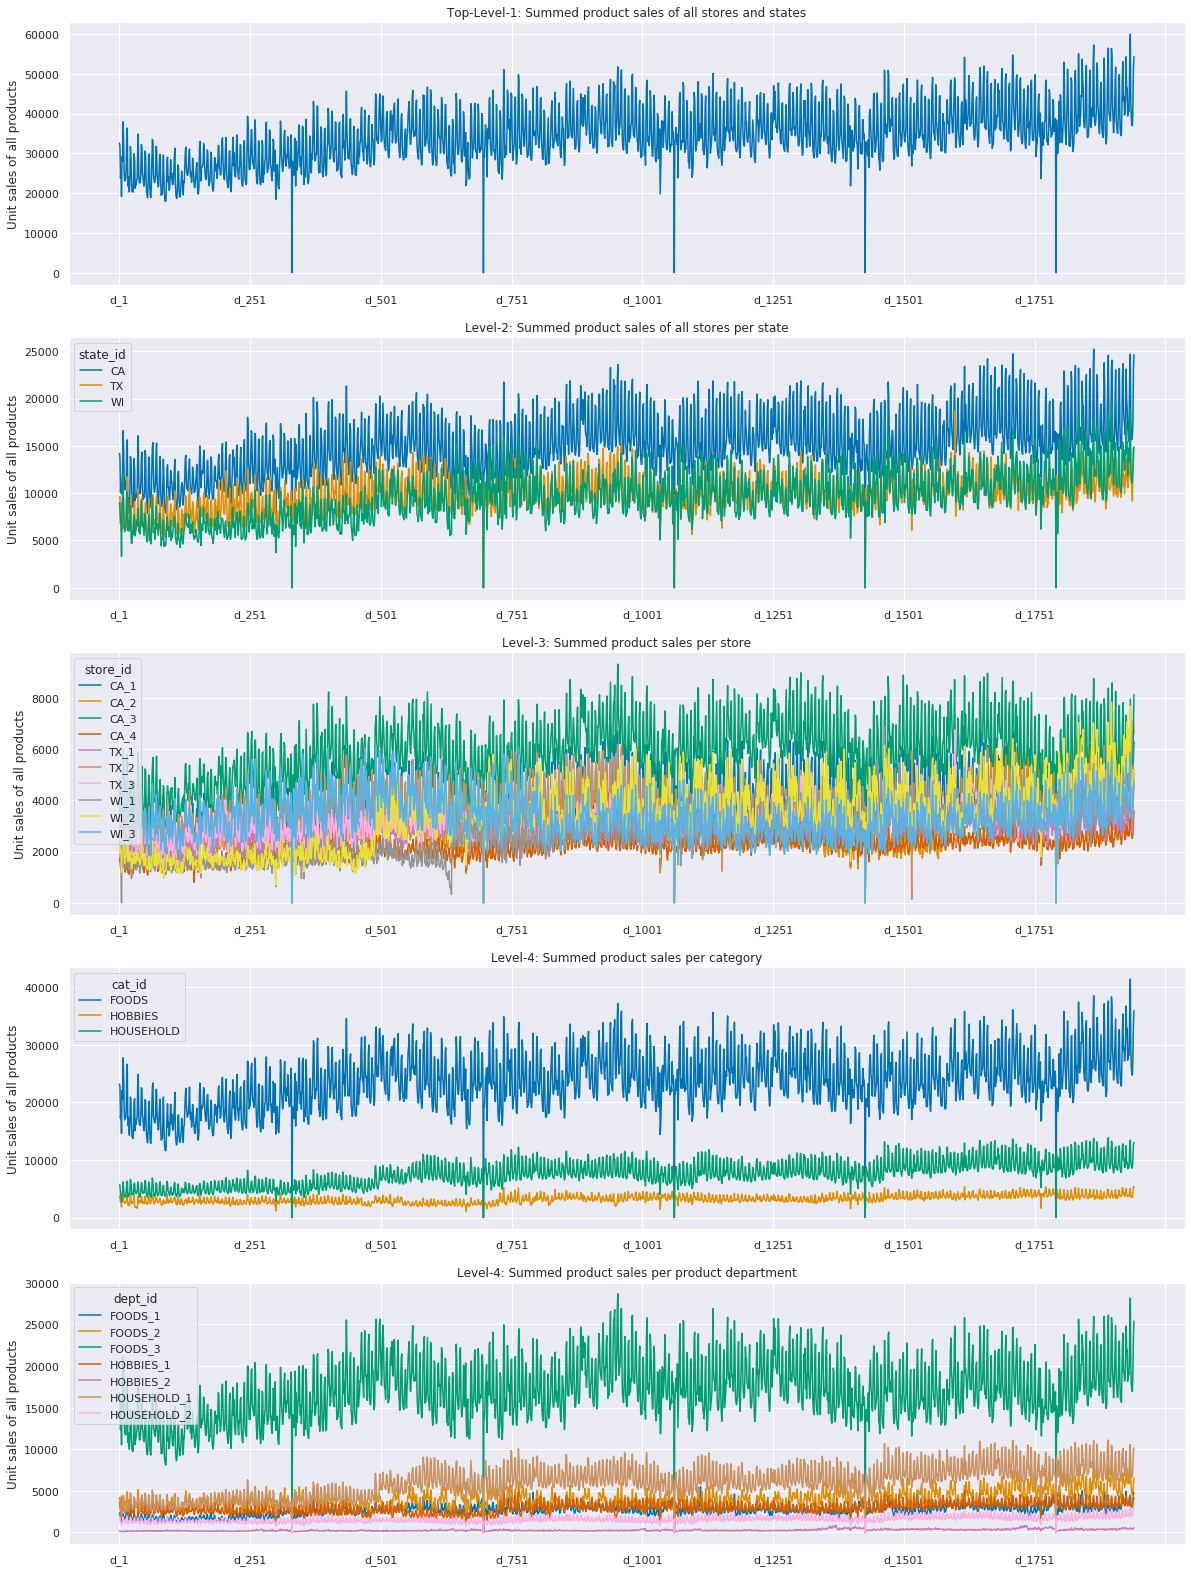

In [26]:
sns.set_palette("colorblind")

fig, ax = plt.subplots(5,1,figsize=(20,28))
df_train[series_cols].sum().plot(ax=ax[0])
ax[0].set_title("Top-Level-1: Summed product sales of all stores and states")
ax[0].set_ylabel("Unit sales of all products");
df_train.groupby("state_id")[series_cols].sum().transpose().plot(ax=ax[1])
ax[1].set_title("Level-2: Summed product sales of all stores per state");
ax[1].set_ylabel("Unit sales of all products");
df_train.groupby("store_id")[series_cols].sum().transpose().plot(ax=ax[2])
ax[2].set_title("Level-3: Summed product sales per store")
ax[2].set_ylabel("Unit sales of all products");
df_train.groupby("cat_id")[series_cols].sum().transpose().plot(ax=ax[3])
ax[3].set_title("Level-4: Summed product sales per category")
ax[3].set_ylabel("Unit sales of all products");
df_train.groupby("dept_id")[series_cols].sum().transpose().plot(ax=ax[4])
ax[4].set_title("Level-4: Summed product sales per product department")
ax[4].set_ylabel("Unit sales of all products");

In [27]:
def find_quartil(l):
    
    if "0.005" in l:
        return 0.005
    elif "0.025" in l:
        return 0.025
    elif "0.165" in l:
        return 0.165
    elif "0.25" in l:
        return 0.25
    elif "0.5" in l:
        return 0.5
    elif "0.75" in l:
        return 0.75
    elif "0.835" in l:
        return 0.835
    elif "0.975" in l:
        return 0.975
    elif "0.995" in l:
        return 0.995
    else:
        return 0
    
def find_state(l):
    if "CA" in l:
        return "CA"
    elif "TX" in l:
        return "TX"
    elif "WI" in l:
        return "WI"
    else:
        return "Unknown"
    
def find_category(l):
    if "FOODS" in l:
        return "foods"
    elif "HOBBIES" in l:
        return "hobbies"
    elif "HOUSEHOLD" in l:
        return "household"
    else:
        return "Unknown"

In [28]:
submission_eda = pd.DataFrame(df_submission.id, columns=["id"])
submission_eda.loc[:, "lb_type"] = np.where(df_submission.id.str.contains("validation"), "validation", "evaluation")
submission_eda.loc[:, "u"] = df_submission.id.apply(lambda l: find_quartil(l))
submission_eda.loc[:, "state"] = df_submission.id.apply(lambda l: find_state(l))
submission_eda.loc[:, "category"] = df_submission.id.apply(lambda l: find_category(l))


NameError: name 'df_submission' is not defined

In [ ]:
submission_eda.head(1)

In [ ]:
submission_eda

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
submission_eda.iloc[:, 1:] 
for col in submission_eda.iloc[:, 1:]:
    submission_eda[col] = le.fit_transform(submission_eda[col])


In [ ]:
#le.classes_

In [ ]:
submission_eda[submission_eda['lb_type']==0]

In [ ]:
idx = 1000
plt.figure(figsize=(20,5))
plt.plot(df_train[series_cols].iloc[idx].values, 'o')
plt.title("Item 445 daily sales in shop CA_1");
plt.xlabel("observed days")
plt.ylabel("Unit sales");

In [ ]:
timeseries = df_train[series_cols].iloc[idx].values
h = 28

train_timeseries = timeseries[0:len(timeseries)-h]
dev_timeseries = timeseries[(len(timeseries)-h)::]

print(len(train_timeseries), len(dev_timeseries))

In [ ]:
naive_val = train_timeseries[-1]
naive_Q = np.ones(dev_timeseries.shape) * naive_val
naive_Q

In [ ]:
def spl_denominator(train_series):
    N = len(train_series)
    sumup = 0
    for n in range(1, N):
        sumup += np.abs(train_series[n]-train_series[n-1])
    return sumup/(N-1)
def spl_numerator(dev_series, Q, u):
    sumup = 0
    for m in range(len(dev_series)):
        if Q[m] <= dev_series[m]:
            sumup += (dev_series[m] - Q[m])*u
        else:
            sumup += (Q[m] - dev_series[m])*(1-u)
    return sumup
def spl(train_series, dev_series, Q, u):
    h = len(dev_series)
    spl_denomina = spl_denominator(train_series)
    spl_numera = spl_numerator(dev_series, Q, u)
    
    return spl_numera/(h*spl_denomina)

In [ ]:
spl(train_timeseries, dev_timeseries, naive_Q, 0.5)

In [ ]:
naive_val

In [ ]:
residuals = train_timeseries - naive_val

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(residuals, ax=ax[0], kde=False)
ax[0].set_xlabel("residuals")
ax[0].set_ylabel("frequency");
ax[0].set_title("Distribution of residuals");

In [ ]:
np.mean(residuals)

In [ ]:
std_dev = np.std(residuals)
std_h = np.ones(dev_timeseries.shape)

for h in range(1, 29):
    std_h[h-1] = std_dev * np.sqrt(h)

In [ ]:
std_h

In [ ]:
y_lower = np.ones(len(std_h))
y_upper = np.ones(len(std_h))
for h in range(len(std_h)):
    low_val = naive_Q[h] - 2.58 * std_h[h]
    if low_val < 0:
        y_lower[h] = 0
    else:
        y_lower[h] = low_val
    y_upper[h] = naive_Q[h] + 2.58 * std_h[h]

In [ ]:
y_lower = np.ones(len(std_h))
y_upper = np.ones(len(std_h))
for h in range(len(std_h)):
    low_val = naive_Q[h] - 2.58 * std_h[h]
    if low_val < 0:
        y_lower[h] = 0
    else:
        y_lower[h] = low_val
    y_upper[h] = naive_Q[h] + 2.58 * std_h[h]

In [ ]:
timeseries = df_train[series_cols].sum().values
len(timeseries)

In [ ]:
train_timeseries = timeseries[0:-28]
eval_timeseries = timeseries[-28::]
print(len(train_timeseries), len(eval_timeseries))
days = np.arange(1, len(series_cols)+1)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(days[0:-28], train_timeseries, label="train")
plt.plot(days[-28::], eval_timeseries, label="validation")
plt.title("Top-Level-1: Summed product sales of all stores and states");
plt.legend()
plt.xlabel("Day")
plt.ylabel("Unit sales");

In [ ]:
dates = df_calendar.iloc[0:len(timeseries)].date.values
df = pd.DataFrame(dates, columns=["ds"])
df.loc[:, "y"] = timeseries
df.head()

In [ ]:
train_df = df.iloc[0:-28]
train_df.shape

In [ ]:
eval_df = df.iloc[-28::]
eval_df.shape

In [ ]:
uncertainty_interval_width = 0.25

In [ ]:
m = Prophet(interval_width=uncertainty_interval_width)
m.fit(train_df)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
forecast.head()

In [ ]:
col_int = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
forecast[col_int].head()

In [ ]:
plt.plot(forecast.iloc[-28::].yhat.values, 'o', label="predicted yhat")
plt.plot(eval_df.y.values, 'o-', label="target")
plt.legend();

In [ ]:
m = Prophet.plot_components

In [ ]:
#fig = Prophet.plot_components(m, forecast)  
#py.iplot(fig)

In [ ]:
uncertainty_interval_width = 0.25

In [ ]:
f_cols = [col for col in df_submission.columns if "F" in col]

In [ ]:
submission_val = df_submission[df_submission.id.str.contains("validation")].copy()

In [ ]:
def plugin_total_predictions():
    interval = [0.5, 0.67, 0.95, 0.99]
    for uncertainty_interval_width in interval: #[0.005, 0.025, 0.165, 0.25]:
        upper = 1-uncertainty_interval_width
        lower = uncertainty_interval_width
    
        m = Prophet(interval_width=uncertainty_interval_width, daily_seasonality=True)
        m.fit(df)
        future = m.make_future_dataframe(periods=28)
        forecast = m.predict(future)
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(lower))),f_cols
        ] = np.round(forecast.yhat_lower.values[-28::])
    
        submission_val.loc[
            (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(upper))),f_cols
        ] = np.round(forecast.yhat_upper.values[-28::])
    
    submission_val.loc[
        (submission_val.id.str.contains("Total")) & (submission_val.id.str.contains(str(0.5))),f_cols
    ] = forecast.yhat.values[-28::]
    
    return submission_val

In [ ]:
submission = pd.DataFrame(submission_val.loc[submission_val.id.str.contains("Total")], columns=df_submission.columns)

In [ ]:
submission.to_csv("Submission.csv")

In [ ]:
submission_val = plugin_total_predictions()
submission_val#.loc[submission_val.id.str.contains("Total")]